# 3D displacement from asc/desc InSAR & azimuth offset

Need the results from:
1. [prep_az_off.ipynb](./1_prep_az_off.ipynb)
2. [prep_rg_off.ipynb](./2_prep_rg_off.ipynb)
3. [prep_ifgram.ipynb](./3_prep_ifgram.ipynb)

In [45]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from skimage.transform import resize
from mintpy.utils import ptime, readfile, writefile, plot as pp, utils as ut
from mintpy.asc_desc2horz_vert import get_design_matrix4east_north_up
from mintpy.cli import view, image_stitch
plt.rcParams.update({'font.size': 12})

S, N, W, E = 35.3, 39.0, 35.0, 39.5   # same as Fig. 1
ref_lat, ref_lon = 36.3, 38.3  # 36.3, 38.5

work_dir = os.path.expanduser('~/data/archives/2023TurkeyEQ/data')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# output
enu_file = os.path.join(work_dir, 'dis_enu.h5')

Go to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/data


## 1. Stitich adjcent tracks

files to be stitched: ['S1_A116_20230204_20230228/offRg_ERA5_SET.geo', 'S1_A014_20230128_20230209/offRg_ERA5_SET.geo']
datasets to be stitched: [None]
##################################################
read displacement from file: S1_A116_20230204_20230228/offRg_ERA5_SET.geo
------------------------------
read data from file: S1_A014_20230128_20230209/offRg_ERA5_SET.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
average offset between two matrices in the common area: 0.2938580244868601
offset all pixel values in the 2nd matrix by 0.2938580244868601 
create output metadata and matrix in shape of (1332, 1620)
plot stitching & shifting result ...
figure size : [12.77, 8.40]
save figure to file: S1_ASC/offRg_ERA5_SET_01.png
##################################################
write file: S1_ASC/offRg_ERA5_SET.geo
write file: S1_ASC/offRg_ERA5_SET.geo.rsc
showing ...


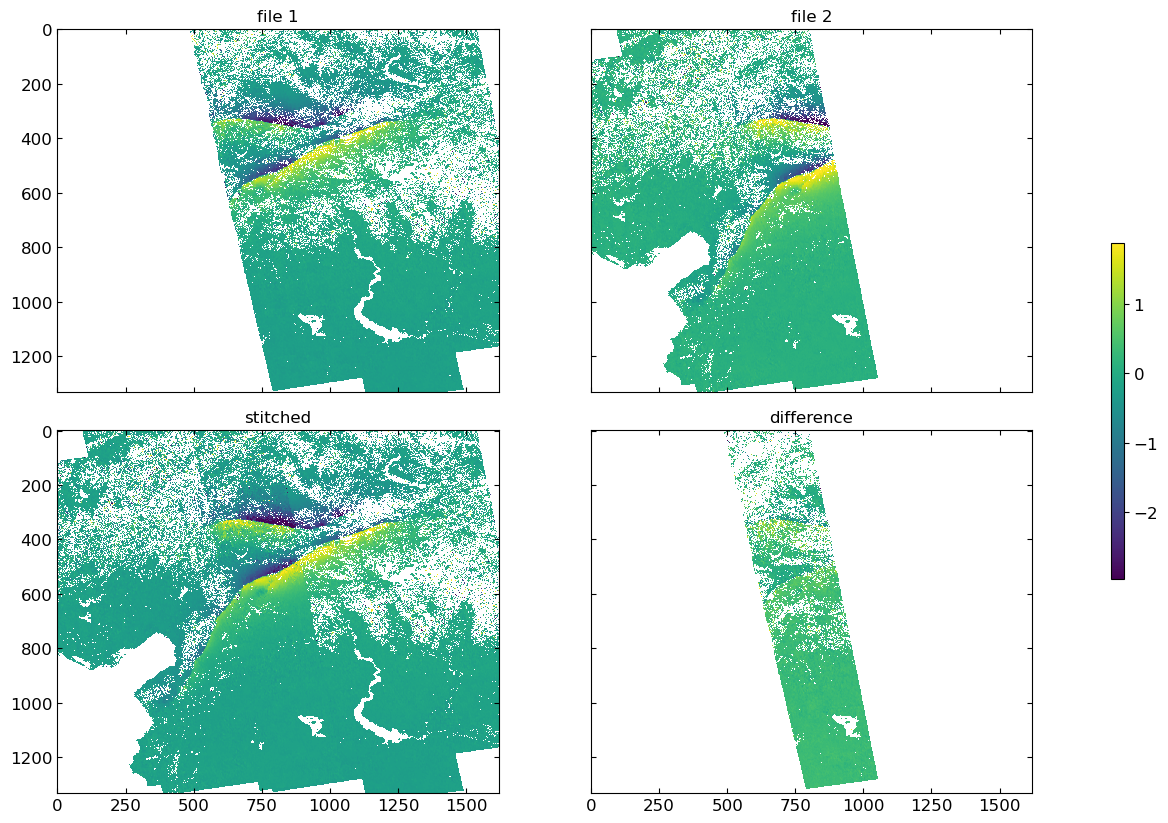

files to be stitched: ['S1_A116_20230204_20230228/offRgStd.geo', 'S1_A014_20230128_20230209/offRgStd.geo']
datasets to be stitched: [None]
##################################################
read filt_dense_offsets from file: S1_A116_20230204_20230228/offRgStd.geo
------------------------------
read data from file: S1_A014_20230128_20230209/offRgStd.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
average offset between two matrices in the common area: 0.016427411000260166
offset all pixel values in the 2nd matrix by 0.016427411000260166 
create output metadata and matrix in shape of (1332, 1620)
plot stitching & shifting result ...
figure size : [12.77, 8.40]
save figure to file: S1_ASC/offRgStd_01.png
##################################################
write file: S1_ASC/offRgStd.geo
write file: S1_ASC/offRgStd.geo.rsc
showing ...


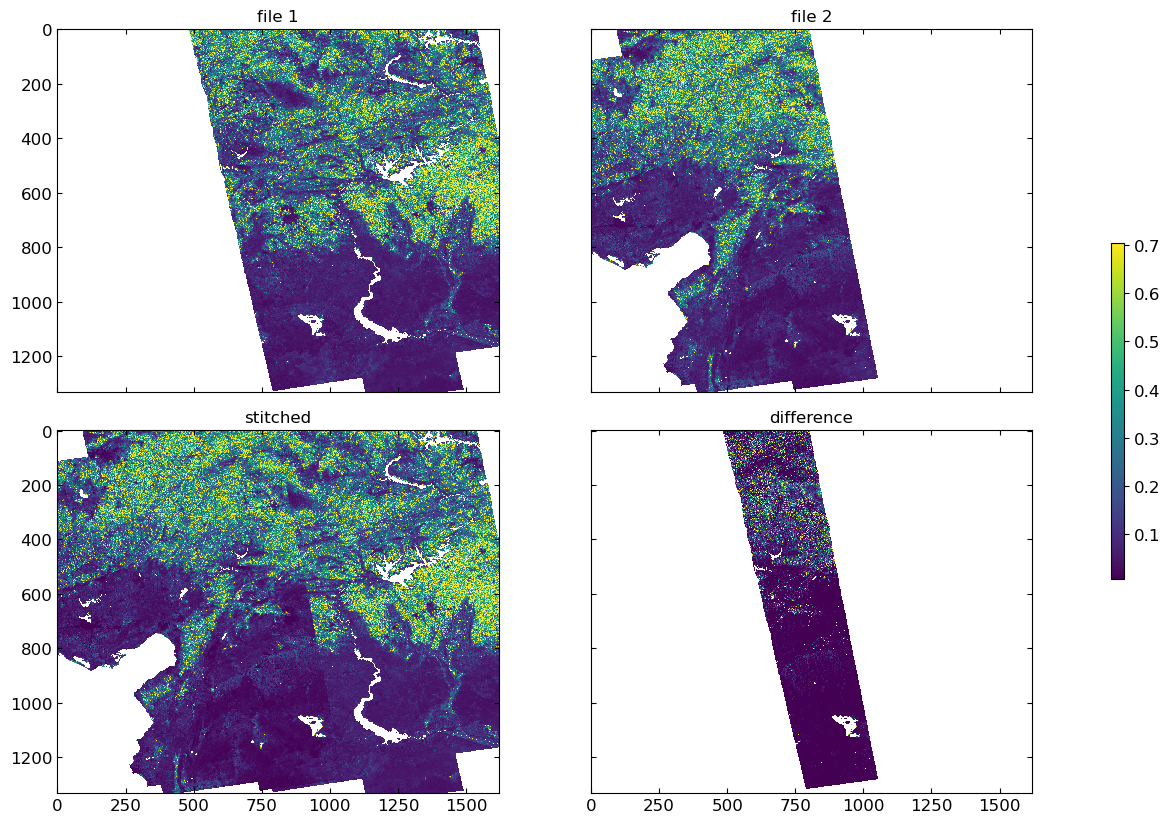

files to be stitched: ['S1_A116_20230204_20230228/offAz.geo', 'S1_A014_20230128_20230209/offAz.geo']
datasets to be stitched: [None]
##################################################
read filt_dense_offsets from file: S1_A116_20230204_20230228/offAz.geo
------------------------------
read data from file: S1_A014_20230128_20230209/offAz.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
average offset between two matrices in the common area: -0.06070100046171957
offset all pixel values in the 2nd matrix by -0.06070100046171957 
create output metadata and matrix in shape of (1332, 1620)
plot stitching & shifting result ...
figure size : [12.77, 8.40]
save figure to file: S1_ASC/offAz_01.png
##################################################
write file: S1_ASC/offAz.geo
write file: S1_ASC/offAz.geo.rsc
showing ...


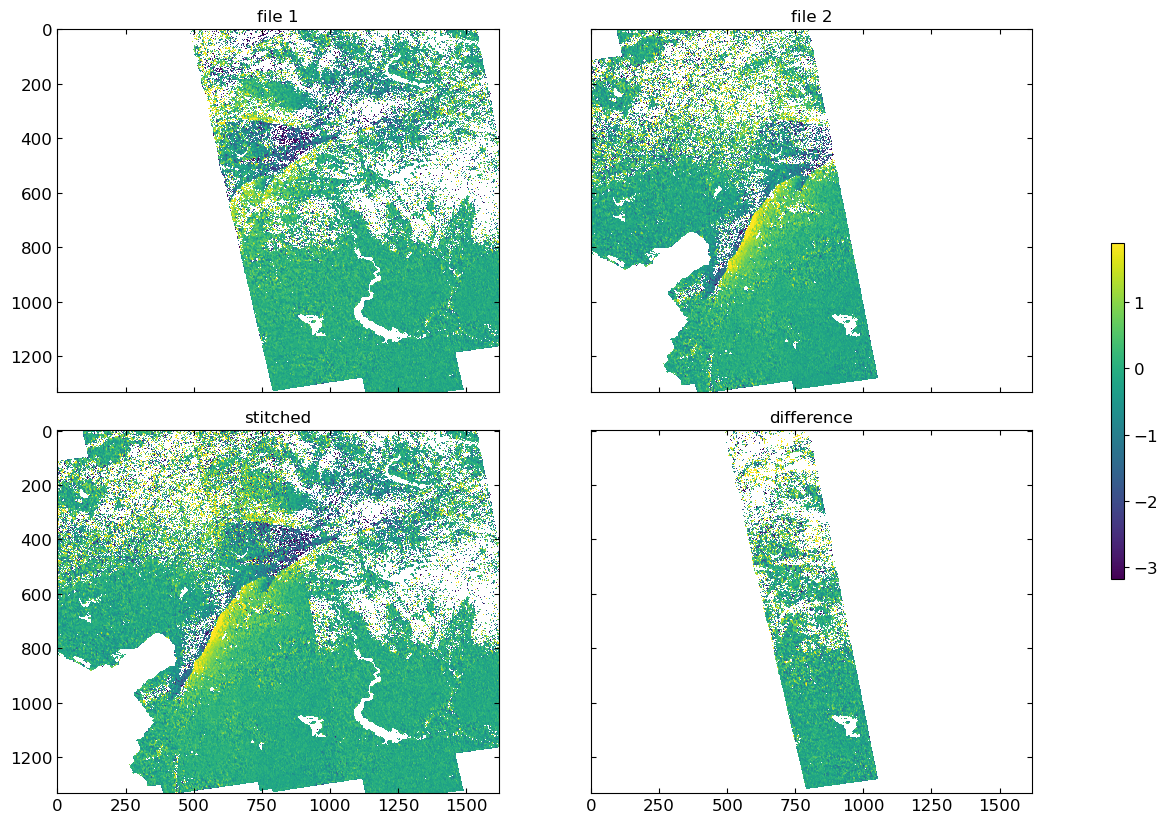

files to be stitched: ['S1_A116_20230204_20230228/offAzStd.geo', 'S1_A014_20230128_20230209/offAzStd.geo']
datasets to be stitched: [None]
##################################################
read filt_dense_offsets from file: S1_A116_20230204_20230228/offAzStd.geo
------------------------------
read data from file: S1_A014_20230128_20230209/offAzStd.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
average offset between two matrices in the common area: -0.022288594715511652
offset all pixel values in the 2nd matrix by -0.022288594715511652 
create output metadata and matrix in shape of (1332, 1620)
plot stitching & shifting result ...
figure size : [12.77, 8.40]
save figure to file: S1_ASC/offAzStd_01.png
##################################################
write file: S1_ASC/offAzStd.geo
write file: S1_ASC/offAzStd.geo.rsc
showing ...


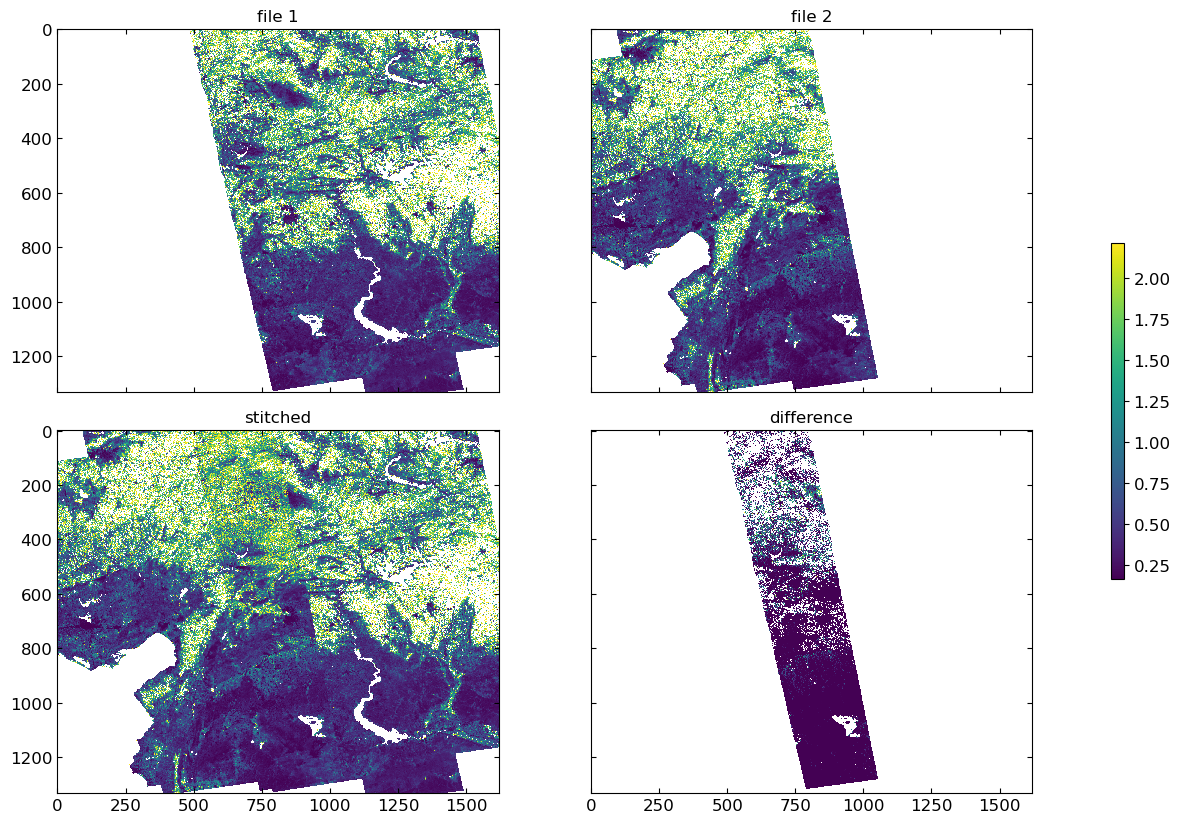

files to be stitched: ['S1_A116_20230204_20230228/los.geo', 'S1_A014_20230128_20230209/los.geo']
datasets to be stitched: [None]
##################################################
read los from file: S1_A116_20230204_20230228/los.geo
------------------------------
read data from file: S1_A014_20230128_20230209/los.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
create output metadata and matrix in shape of (1332, 1620)
##################################################
write file: S1_ASC/los.geo
write file: S1_ASC/los.geo.rsc
showing ...


In [50]:
dnames = ['S1_A116_20230204_20230228', 'S1_A014_20230128_20230209']
fbases = ['offRg_ERA5_SET.geo', 'offRgStd.geo', 'offAz.geo', 'offAzStd.geo', 'los.geo']
opts = ['', '', '', '', '--no-offset']
for fbase, opt in zip(fbases, opts):
    image_stitch.main(f'{dnames[0]}/{fbase} {dnames[1]}/{fbase} -o S1_ASC/{fbase} {opt}'.split())

## 1. Read (and resize) displacement and geometry

In [60]:
# inputs
# ALL files MUST be geocoded into the same bounding box (SNWE)
# The 1st file is used as the grid size reference for the output
fnames = [
    os.path.join(work_dir, 'ALOS2_A184_20220905_20230220/geo_filt_msk_ERA5_SET.unw'),
    os.path.join(work_dir, 'ALOS2_D077_20220916_20230217/geo_filt_msk_ERA5_SET.unw'),
    os.path.join(work_dir, 'S1_ASC/offRg_ERA5_SET.geo'),
    os.path.join(work_dir, 'S1_ASC/OffAz.geo'),
    os.path.join(work_dir, 'S1_D021_20230129_20230210/offRg_ERA5_SET.geo'),
    os.path.join(work_dir, 'S1_D021_20230129_20230210/OffAz.geo'),
]
num_file = len(fnames)
obs_direction = np.array(['range', 'range', 'range', 'azimuth', 'range', 'azimuth'])

In [65]:
atr = readfile.read_attribute(fnames[0])
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
# calculate reference point in y/x

dis_list, inc_angle_list, az_angle_list = [], [], []
for i, fname in enumerate(fnames):
    # read displacement
    print(f'read data from file: {fname}')
    dis, atr = readfile.read(fname)
    # convert phase to range
    if fname.endswith('.unw'):
        dis *= float(atr['WAVELENGTH']) / (4.0 * np.pi)
    # make positive range change for motion towards the satellite
    # to be consistent with the design matrix convention from mintpy.asc_desc2horz_vert.py
    if obs_direction[i] == 'range':
        dis *= -1

    # read geometry
    los_file = os.path.join(os.path.dirname(fname), 'los.geo')
    inc_angle = readfile.read(los_file, datasetName='incidenceAngle')[0];  inc_angle[inc_angle == 0] = np.nan
    az_angle  = readfile.read(los_file, datasetName='azimuthAngle')[0];    az_angle[az_angle == 0] = np.nan

    # spatial referencing
    coord = ut.coordinate(atr)
    ref_y, ref_x = coord.geo2radar(ref_lat, ref_lon)[:2]
    print(f'\tspatial referencing to (lat, lon) = ({ref_lat}, {ref_lon}), (y, x) = ({ref_y}, {ref_x})')
    if np.isnan(dis[ref_y, ref_x]):
        raise ValueError('reference point is in masked out region! Choose a different one!')
    dis -= dis[ref_y, ref_x]

    # resize
    if dis.shape != (length, width):
        print(f'\tresizing shape from {dis.shape} to {(length,width)}')
        dis       = resize(dis,       (length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)
        inc_angle = resize(inc_angle, (length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)
        az_angle  = resize(az_angle,  (length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)

    dis_list.append(dis)
    inc_angle_list.append(inc_angle)
    az_angle_list.append(az_angle)
dis_mat = np.array(dis_list, dtype=np.float32)
inc_angle_mat = np.array(inc_angle_list, dtype=np.float32)
az_angle_mat = np.array(az_angle_list, dtype=np.float32)
del dis_list, inc_angle_list, az_angle_list
print('finished reading data.')

read data from file: /Users/yunjunz/data/archives/2023TurkeyEQ/data/ALOS2_A184_20220905_20230220/geo_filt_msk_ERA5_SET.unw
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (3240, 3960)
read data from file: /Users/yunjunz/data/archives/2023TurkeyEQ/data/ALOS2_D077_20220916_20230217/geo_filt_msk_ERA5_SET.unw
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (3240, 3960)
read data from file: /Users/yunjunz/data/archives/2023TurkeyEQ/data/S1_ASC/offRg_ERA5_SET.geo
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (972, 1188)
	resizing shape from (1332, 1620) to (4440, 5400)
read data from file: /Users/yunjunz/data/archives/2023TurkeyEQ/data/S1_ASC/OffAz.geo
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (972, 1188)
	resizing shape from (1332, 1620) to (4440, 5400)
read data from file: /Users/yunjunz/data/archives/2023TurkeyEQ/data/S1_D021_20230129_20230210/offRg_ERA5_SET.geo
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (972, 1188)


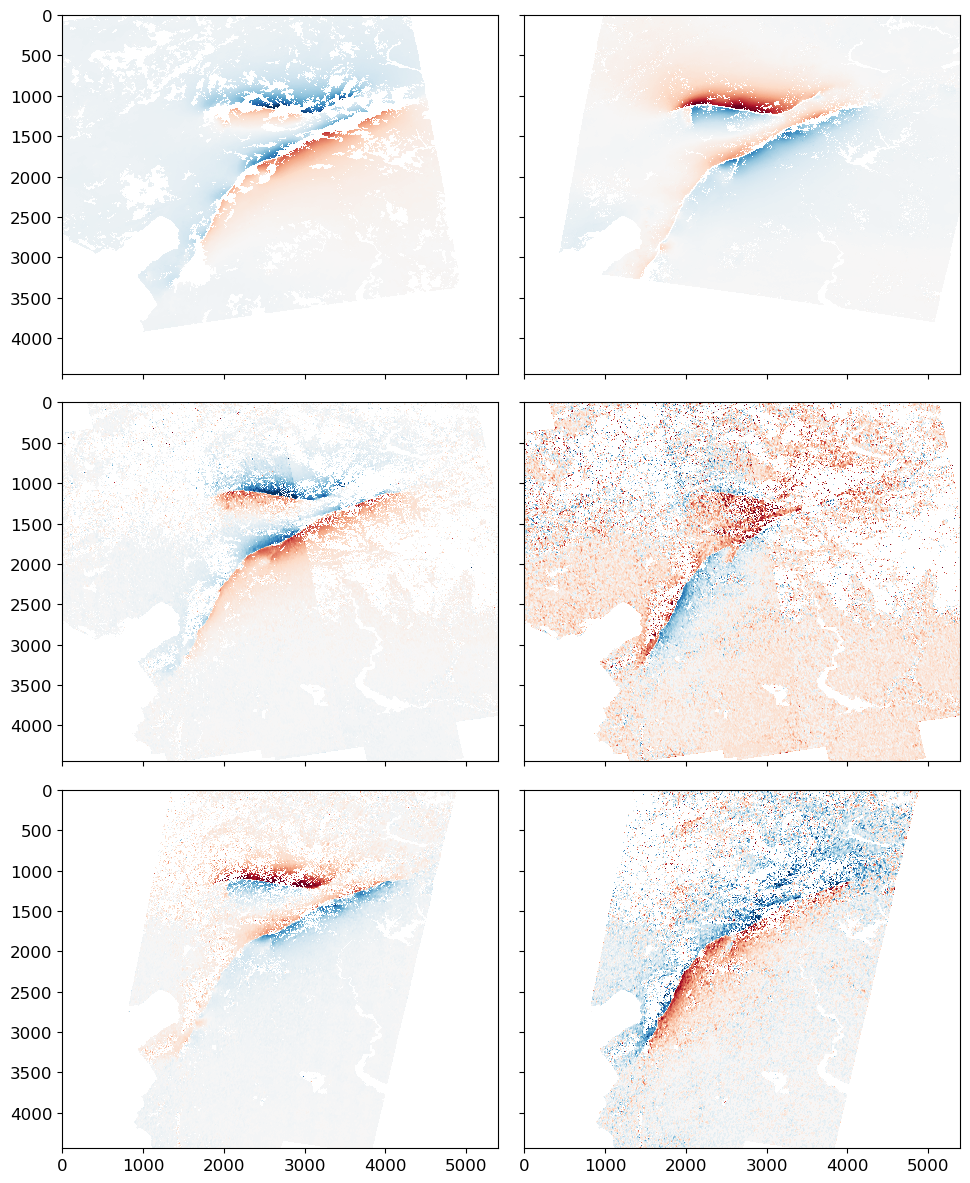

In [66]:
# plot
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=[10, 12], sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    im = ax.imshow(dis_mat[i,:], vmin=-3, vmax=3, cmap='RdBu', interpolation='nearest')
fig.tight_layout()

# axis format
#caxs = [fig.add_axes([1.0, 0.75, 0.01, 0.15]),
#        fig.add_axes([1.0, 0.45, 0.01, 0.15]),
#        fig.add_axes([1.0, 0.10, 0.01, 0.15])]
#for im, cax in zip([im1, im2, im3], caxs):
#    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
plt.show()

## 2. Estimate 3D displacement field

In [67]:
## mean geometry
#G = get_design_matrix4east_north_up(los_inc_angle=np.nanmedian(inc_angle_mat, axis=(1,2)),
#                                    los_az_angle=np.nanmedian(az_angle_mat, axis=(1,2)),
#                                    obs_direction=obs_direction)
#dis_enu = np.dot(np.linalg.pinv(G), dis_mat.reshape(num_file, -1)).reshape(3, length, width)

# pixel-wise geometry with step
dis_enu = np.zeros((3, length, width), dtype=np.float32) * np.nan
step = 20
num_row = np.ceil(length / step).astype(int)
num_col = np.ceil(width / step).astype(int)
prog_bar = ptime.progressBar(maxValue=num_row)
for i in range(num_row):
    y0, y1 = step * i, min(step * (i + 1), length)
    for j in range(num_col):
        x0, x1 = step * j, min(step * (j + 1), width)
        los_inc_angle = np.nanmedian(inc_angle_mat[:, y0:y1, x0:x1], axis=(1,2))
        los_az_angle = np.nanmedian(az_angle_mat[:, y0:y1, x0:x1], axis=(1,2))
        if np.all(~np.isnan(los_inc_angle)):
            G = get_design_matrix4east_north_up(los_inc_angle, los_az_angle, obs_direction)
            dis_enu_ij = np.dot(np.linalg.pinv(G), dis_mat[:, y0:y1, x0:x1].reshape(num_file, -1))
            dis_enu[:, y0:y1, x0:x1] = dis_enu_ij.reshape(3, y1-y0, x1-x0)
    prog_bar.update(i+1, every=1, suffix=f'{i+1} / {num_row}')
prog_bar.close()

[==================================================] 222 / 222   25s /     0s 


### a. Write result to HDF5 file

In [68]:
# write to HDF5 file
ds_dict = {'east'  : dis_enu[0].reshape(length, width),
           'north' : dis_enu[1].reshape(length, width),
           'up'    : dis_enu[2].reshape(length, width)}
atr['FILE_TYPE'] = 'displacement'
atr['DATA_TYPE'] = 'float32'
atr['UNIT'] = 'm'
atr['BANDS'] = '3'
atr['REF_Y'], atr['REF_X'] = ref_y, ref_x
atr['REF_LAT'], atr['REF_LON'] = ut.coordinate(atr).radar2geo(ref_y, ref_x)[:2]
writefile.write(ds_dict, enu_file, metadata=atr)

delete exsited file: /Users/yunjunz/data/archives/2023TurkeyEQ/data/dis_enu.h5
create HDF5 file: /Users/yunjunz/data/archives/2023TurkeyEQ/data/dis_enu.h5 with w mode
create dataset /east  of float32    in size of (4440, 5400)         with compression=None
create dataset /north of float32    in size of (4440, 5400)         with compression=None
create dataset /up    of float32    in size of (4440, 5400)         with compression=None
finished writing to /Users/yunjunz/data/archives/2023TurkeyEQ/data/dis_enu.h5


'/Users/yunjunz/data/archives/2023TurkeyEQ/data/dis_enu.h5'

### b. Quality check

save figure to file /Users/yunjunz/data/archives/2023TurkeyEQ/data/dis_enu.png


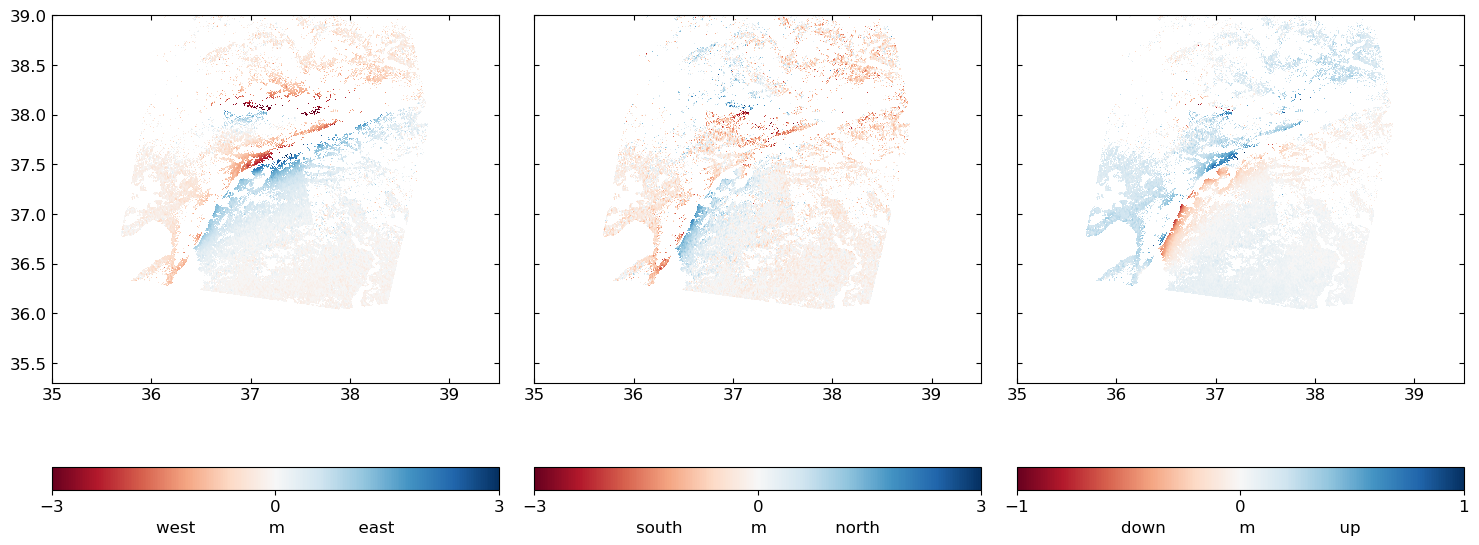

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharex=True, sharey=True)
kwargs = dict(extent=(W, E, S, N), cmap='RdBu', interpolation='nearest')
vlims = [3, 3, 1]
im1 = axs[0].imshow(dis_enu[0,:].reshape(length, width), vmin=-vlims[0], vmax=vlims[0], **kwargs)
im2 = axs[1].imshow(dis_enu[1,:].reshape(length, width), vmin=-vlims[1], vmax=vlims[1], **kwargs)
im3 = axs[2].imshow(dis_enu[2,:].reshape(length, width), vmin=-vlims[2], vmax=vlims[2], **kwargs)
ims = [im1, im2, im3]
labels = ['west              m              east',
          'south             m             north',
          'down              m                up']
for i, (ax, im, label, vlim) in enumerate(zip(axs, ims, labels, vlims)):
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=[-vlim, 0, vlim])
    cbar.set_label(label)
fig.tight_layout()
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

# output
out_fig = os.path.abspath('dis_enu.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()